<a href="https://colab.research.google.com/github/Madhukiranchiti/RTML/blob/main/Assignment%202_chiti_RTML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2
## Course : Real-Time Machine Learning 5106
### Name : Madhu Kiran Chiti
### Student ID : 801333676
#### 02/16/2024


In [ ]:
!pip install d2l==1.0.0
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from matplotlib import pyplot as plt

import torch
from d2l import torch as d2l
from torch import nn
from torchvision import datasets,transforms

!pip install ptflops
import ptflops
from ptflops import get_model_complexity_info

from torch.utils.data import DataLoader, random_split, Subset

from torch.nn import functional as F
!pip install torchmetrics
from torchmetrics.classification import MulticlassAccuracy, BinaryAccuracy
from torchmetrics import ConfusionMatrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 99.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 116.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.6 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 18.1 MB/s eta 0:00:00


In [ ]:
train_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                      transforms.Resize(64),
                                        transforms.Normalize((0.29), (0.32)),
])

test_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                     transforms.Resize(64),
                                        transforms.Normalize((0.29), (0.32)),
])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)


train_cifar, valid_cifar = random_split(cifar_trainset, [0.8, 0.2])
trainLoader = DataLoader(train_cifar, batch_size=256, shuffle=True, num_workers=1)
validateLoader = DataLoader(valid_cifar, batch_size=256, shuffle=True, num_workers=1)
testLoader = DataLoader(cifar_testset, batch_size=256, shuffle=True, num_workers=1)

100%|██████████| 170498071/170498071 [00:13<00:00, 12786633.12it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class Train_Model: # A class to train and save the developed model and the metrics


    def __init__(self, model, loss, optimizer, accuracy, model_type, device, classes=0):

        self.device = device
        self.model = model.to(device) ## Setting the model on GPU
        self.Loss_Function = loss
        self.optimizer = optimizer
        self.accuracy = accuracy
        self.model_type = model_type
        self.classNum = classes

        # A dictionary to append or store the results
        self.Metrics = {"Training_Loss":[],"Training_Accuracy":[], "Validation_Loss":[], "Validation_Accuracy":[],"Test_Accuracy":0}
        self.ConfMatrix = None

    # Function to train the model
    def model_run(self, l_data,run_type):

        if run_type == 'train':
          self.model.train()

          if self.model_type == "Classification":
              MCA = self.accuracy(self.classNum)
          else:
              MCA = self.accuracy

          loss_sum = 0
          acc = 0

          # Iterates over the data
          for data, labels in tqdm(l_data):

              # transform data into one-hot vectors
              data = data.to(self.device)
              if self.model_type == "Classification":
                  labels = torch.eye(10)[labels]
              else:
                  labels = labels.reshape(-1, 1)
              labels = labels.to(self.device)

              predictions = self.model(data)
              loss_value = self.Loss_Function(predictions, labels)


              self.optimizer.zero_grad()
              loss_value.backward()
              self.optimizer.step()


              # Set the predictions and labels back into integers for accuracy calculation
              if self.model_type == "Classification":
                  predictions = torch.Tensor([torch.argmax(i).item() for i in predictions])
                  labels = torch.Tensor([torch.argmax(i).item() for i in labels])

              ##### Calculate Loss and accuracy
              loss_sum += loss_value.item()
              if self.model_type == "Classification":
                  acc += MCA(predictions, labels)

          self.Metrics["Training_Loss"].append(loss_sum / len(l_data))
          if self.model_type == "Classification":
              self.Metrics["Training_Accuracy"].append(acc / len(l_data))


        elif run_type == 'eval':
          self.model.eval()

          if self.model_type == "Classification":
              MCA = self.accuracy(self.classNum)
          else:
              MCA = self.accuracy

          loss_sum = 0
          acc = 0

          for data, labels in l_data:

              data = data.to(self.device)
              if self.model_type == "Classification":
                  labels = torch.eye(10)[labels]
              else:
                  labels = labels.reshape(-1, 1)
              labels = labels.to(self.device)

              with torch.no_grad():
                  predictions = self.model(data)
              loss_value = self.Loss_Function(predictions, labels)

              if self.model_type == "Classification":
                  predictions = torch.Tensor([torch.argmax(i).item() for i in predictions])
                  labels = torch.Tensor([torch.argmax(i).item() for i in labels])

              loss_sum += loss_value.item()
              if self.model_type == "Classification":
                  acc += MCA(predictions, labels)

          self.Metrics["Validation_Loss"].append(loss_sum / len(l_data))
          if self.model_type == "Classification":
              self.Metrics["Validation_Accuracy"].append(acc / len(l_data))


    def fit(self, t_data, v_data, EPOCHS):


        for i in range(EPOCHS):

            self.model_run(v_data,'eval')
            self.model_run(t_data,'train')

            print("Current Epoch:", i+1)
            print("Training_Loss:", self.Metrics["Training_Loss"][-1], " | Validation_Loss:", self.Metrics["Validation_Loss"][-1])
            if self.model_type == "Classification":
                print("Training_Accuracy:", self.Metrics["Training_Accuracy"][-1].item(), " | Validation_Accuracy:", self.Metrics["Validation_Accuracy"][-1].item())


    def Test_Model(self, testLoader):

        self.model.eval()

        if self.model_type == "Classification":
            confusion = ConfusionMatrix(task="multiclass", num_classes=self.classNum)
            MCA = self.accuracy(self.classNum)
        else:
            MCA = self.accuracy

        predMax = torch.empty(0)
        labelMax = torch.empty(0)

        for data, labels in testLoader:

            data = data.to(self.device)
            if self.model_type == "Classification":
                labels = torch.eye(10)[labels]
            else:
                labels = labels.reshape(-1, 1)
            labels = labels.to(self.device)

            with torch.no_grad():
                pred = self.model(data)

            if self.model_type == "Classification":
                pred = torch.Tensor([torch.argmax(i).item() for i in pred])
                labels = torch.Tensor([torch.argmax(i).item() for i in labels])

            predMax = torch.cat((predMax, pred))
            labelMax = torch.cat((labelMax, labels))

        if self.model_type == "Classification":
            self.ConfMatrix = confusion(predMax, labelMax)
            self.Metrics["Test_Accuracy"] = MCA(predMax, labelMax).item()




In [ ]:
def init_cnn(module):
  if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)


In [ ]:
#@d2l.add_to_class(d2l.Trainer)
def __init__(self, max_epochs, num_gpus=1, gradient_clip_val=0):
        self.save_hyperparameters()
        self.train_loss = []
        self.train_acc = []
        self.valid_loss = []
        self.valid_acc = []

        assert num_gpus == 1,'No GPU support yet'


In [ ]:
# @d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)



In [ ]:
#@d2l.add_to_class(d2l.Module)
def training_step(self, batch):
  l = self.loss(self(*batch[:-1]), batch[-1])
  self.plot('loss', l, train=True)
  self.train_loss.append(l)
  return l

#@d2l.add_to_class(d2l.Module)
def validation_step(self, batch):
  l = self.loss(self(*batch[:-1]), batch[-1])
  self.valid_loss.append(l)
  self.plot('loss', l, train=False)

In [ ]:
#@d2l.add_to_class(d2l.Module)
def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
            metric_type = 'train'
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
            metric_type = 'val'
        self.board.draw(x, d2l.numpy(d2l.to(value, d2l.cpu())),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

        if not train and self.trainer.epoch % 1 == 0:
          train_loss = self.trainer.train_loss[-1]
          #train_acc = self.trainer.train_acc[-1]
          val_loss = self.trainer.valid_loss[-1]
          #val_acc = self.trainer.valid_acc[-1]
          print(f"Epoch [{self.trainer.epoch+1}/{self.trainer.epochs}]: "
                f"train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f}, ")
               # f"val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}")

In [ ]:
#@d2l.add_to_class(d2l.Trainer)
def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
            self.evaluate()

In [ ]:
device_to_use = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Problem 1:

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
num_classes = 2
model = AlexNet(num_classes)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32
image_height = 227
image_width = 227
train_dir = "./content/train"
valid_dir = "./content/validation"
model_dir = "./my_model.h5"

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Current Epoch: 1
Training_Loss: 2.272609487460677  | Validation_Loss: 2.302513539791107
Training_Accuracy: 0.1294616311788559  | Validation_Accuracy: 0.10107139497995377



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 2
Training_Loss: 2.0155183243903383  | Validation_Loss: 2.2355122208595275
Training_Accuracy: 0.18505646288394928  | Validation_Accuracy: 0.1392045021057129



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 3
Training_Loss: 1.8469725171471858  | Validation_Loss: 1.9898792028427124
Training_Accuracy: 0.2682618498802185  | Validation_Accuracy: 0.17369350790977478



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 4
Training_Loss: 1.6819514992890086  | Validation_Loss: 1.67612124979496
Training_Accuracy: 0.3537515103816986  | Validation_Accuracy: 0.33480408787727356



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 5
Training_Loss: 1.5211788917043407  | Validation_Loss: 1.705889317393303
Training_Accuracy: 0.4387112855911255  | Validation_Accuracy: 0.3662897050380707



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 6
Training_Loss: 1.4075208742907093  | Validation_Loss: 1.5276809692382813
Training_Accuracy: 0.49665939807891846  | Validation_Accuracy: 0.43439212441444397



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 7
Training_Loss: 1.3476789179880908  | Validation_Loss: 1.3819499522447587
Training_Accuracy: 0.5286444425582886  | Validation_Accuracy: 0.5039705038070679



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 8
Training_Loss: 1.2569313398592032  | Validation_Loss: 1.279677504301071
Training_Accuracy: 0.5649591684341431  | Validation_Accuracy: 0.5617924928665161



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 9
Training_Loss: 1.2264320561840276  | Validation_Loss: 1.3133323580026626
Training_Accuracy: 0.5805141925811768  | Validation_Accuracy: 0.5331199765205383



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 10
Training_Loss: 1.1478407667700652  | Validation_Loss: 1.1786615133285523
Training_Accuracy: 0.6137138605117798  | Validation_Accuracy: 0.5934191942214966



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Time Taken to Train: 0:06:13.322411
alexnet_Model Train Accuracy: 0.6137138605117798
alexnet_Model Test Accuracy: 0.58079993724823
Macs:94.26 MMac | Params:57.04 M


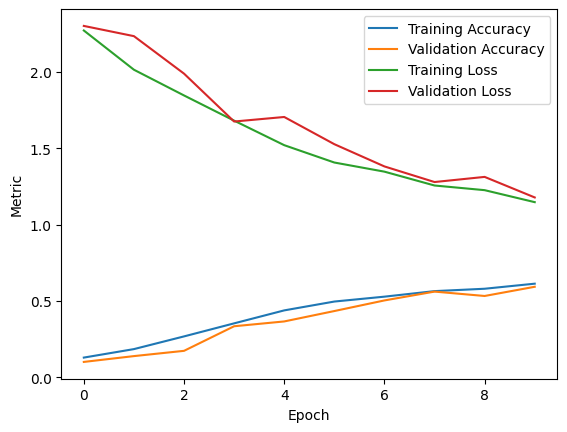

In [ ]:
alexnet_arch = AlexNet()

alexnet_Model = Train_Model(alexnet_arch, nn.CrossEntropyLoss(), torch.optim.SGD(alexnet_arch.parameters(), lr=0.1, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
alexnet_Model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

alexnet_Model.Test_Model(testLoader)

macs, params = get_model_complexity_info(alexnet_Model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("alexnet_Model Train Accuracy:", alexnet_Model.Metrics["Training_Accuracy"][-1].item())
print("alexnet_Model Test Accuracy:", alexnet_Model.Metrics["Test_Accuracy"])


alexnet_Model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(alexnet_Model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(alexnet_Model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(alexnet_Model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(alexnet_Model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

## **Dropout = 0.5**

In [ ]:
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),  # Adding dropout with probability 0.5
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # Adding dropout with probability 0.5
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
num_classes = 2
model = AlexNet(num_classes)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32
image_height = 227
image_width = 227
train_dir = "./content/train"
valid_dir = "./content/validation"
model_dir = "./my_model.h5"

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Current Epoch: 1
Training_Loss: 2.245490306501935  | Validation_Loss: 2.302636855840683
Training_Accuracy: 0.13266621530056  | Validation_Accuracy: 0.09749995917081833



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 2
Training_Loss: 1.9542507715285964  | Validation_Loss: 2.2072371423244475
Training_Accuracy: 0.2184387445449829  | Validation_Accuracy: 0.18112002313137054



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 3
Training_Loss: 1.7879390944341185  | Validation_Loss: 1.736662694811821
Training_Accuracy: 0.3133629560470581  | Validation_Accuracy: 0.30123046040534973



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 4
Training_Loss: 1.628773583728037  | Validation_Loss: 1.7449547082185746
Training_Accuracy: 0.38355162739753723  | Validation_Accuracy: 0.3684428632259369



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 5
Training_Loss: 1.4641038915913576  | Validation_Loss: 1.6368000119924546
Training_Accuracy: 0.46625620126724243  | Validation_Accuracy: 0.40191730856895447



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 6
Training_Loss: 1.3805595689518437  | Validation_Loss: 1.526790690422058
Training_Accuracy: 0.5045983195304871  | Validation_Accuracy: 0.45400938391685486



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 7
Training_Loss: 1.2769845678548144  | Validation_Loss: 1.4291461676359176
Training_Accuracy: 0.5545710921287537  | Validation_Accuracy: 0.5332509875297546



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 8
Training_Loss: 1.1996330273379185  | Validation_Loss: 1.2306805208325386
Training_Accuracy: 0.5886439681053162  | Validation_Accuracy: 0.5807527303695679



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 9
Training_Loss: 1.1268129280418346  | Validation_Loss: 1.2286300167441369
Training_Accuracy: 0.6165273785591125  | Validation_Accuracy: 0.593727707862854



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 10
Training_Loss: 1.0985172808549966  | Validation_Loss: 1.1479583472013473
Training_Accuracy: 0.6282013058662415  | Validation_Accuracy: 0.5924299359321594



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Time Taken to Train: 0:05:53.291937
alexnet_Model Train Accuracy: 0.6282013058662415
alexnet_Model Test Accuracy: 0.5961999893188477
Macs:94.26 MMac | Params:57.04 M


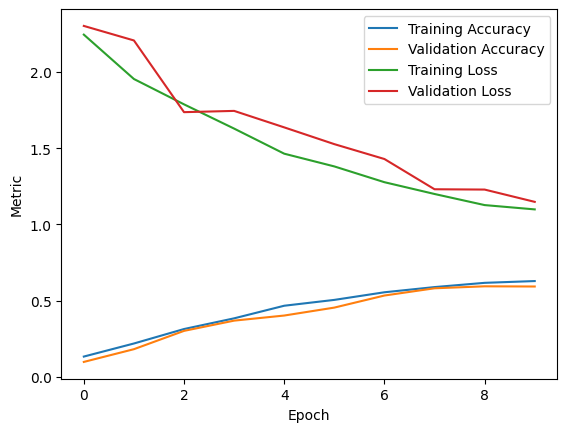

In [ ]:
alexnet_arch = AlexNet()

alexnet_Model = Train_Model(alexnet_arch, nn.CrossEntropyLoss(), torch.optim.SGD(alexnet_arch.parameters(), lr=0.1, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
alexnet_Model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

alexnet_Model.Test_Model(testLoader)

macs, params = get_model_complexity_info(alexnet_Model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("alexnet_Model Train Accuracy:", alexnet_Model.Metrics["Training_Accuracy"][-1].item())
print("alexnet_Model Test Accuracy:", alexnet_Model.Metrics["Test_Accuracy"])


alexnet_Model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(alexnet_Model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(alexnet_Model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(alexnet_Model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(alexnet_Model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

## **Dropout = 0.6**

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Current Epoch: 1
Training_Loss: 2.2210599624427263  | Validation_Loss: 2.30269131064415
Training_Accuracy: 0.1397625207901001  | Validation_Accuracy: 0.09786717593669891



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 2
Training_Loss: 1.8880734420885705  | Validation_Loss: 2.0133882850408553
Training_Accuracy: 0.23997914791107178  | Validation_Accuracy: 0.17687171697616577



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 3
Training_Loss: 1.72666918320261  | Validation_Loss: 1.8644040882587434
Training_Accuracy: 0.3275243937969208  | Validation_Accuracy: 0.2690654397010803



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 4
Training_Loss: 1.540544717934481  | Validation_Loss: 1.6621564656496048
Training_Accuracy: 0.43784192204475403  | Validation_Accuracy: 0.3383232057094574



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 5
Training_Loss: 1.374528067127155  | Validation_Loss: 1.3609750032424928
Training_Accuracy: 0.5164265036582947  | Validation_Accuracy: 0.49977120757102966



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 6
Training_Loss: 1.2758190115545964  | Validation_Loss: 1.3355619579553604
Training_Accuracy: 0.5557224750518799  | Validation_Accuracy: 0.5299681425094604



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 7
Training_Loss: 1.1976379239635102  | Validation_Loss: 1.291958737373352
Training_Accuracy: 0.588354229927063  | Validation_Accuracy: 0.5513886213302612



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 8
Training_Loss: 1.1709335776650982  | Validation_Loss: 1.191469743847847
Training_Accuracy: 0.6021069288253784  | Validation_Accuracy: 0.59461909532547



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 9
Training_Loss: 1.1098229156178274  | Validation_Loss: 1.1499564856290818
Training_Accuracy: 0.6267372369766235  | Validation_Accuracy: 0.5977233052253723



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 10
Training_Loss: 1.0648459313781398  | Validation_Loss: 1.1294778883457184
Training_Accuracy: 0.6429889798164368  | Validation_Accuracy: 0.6158494353294373



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Time Taken to Train: 0:05:50.717481
alexnet_Model Train Accuracy: 0.6429889798164368
alexnet_Model Test Accuracy: 0.6003999710083008
Macs:94.26 MMac | Params:57.04 M


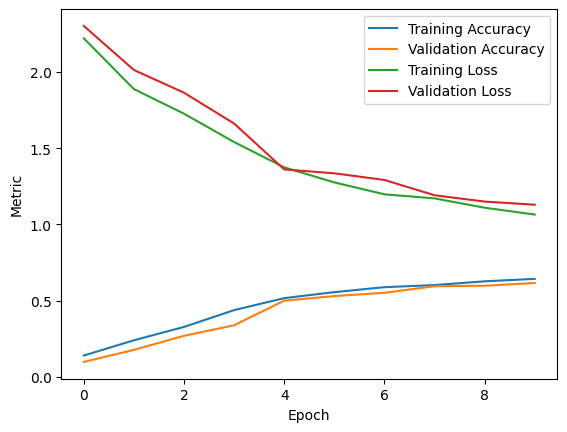

In [ ]:
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.6),  # Changing dropout probability to 0.6
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6),  # Changing dropout probability to 0.6
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


num_classes = 2
model = AlexNet(num_classes)

EPOCHS = 10
BATCH_SIZE = 32
image_height = 227
image_width = 227
train_dir = "./content/train"
valid_dir = "./content/validation"
model_dir = "./my_model.h5"

alexnet_arch = AlexNet()

alexnet_Model = Train_Model(alexnet_arch, nn.CrossEntropyLoss(), torch.optim.SGD(alexnet_arch.parameters(), lr=0.1, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
alexnet_Model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

alexnet_Model.Test_Model(testLoader)

macs, params = get_model_complexity_info(alexnet_Model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("alexnet_Model Train Accuracy:", alexnet_Model.Metrics["Training_Accuracy"][-1].item())
print("alexnet_Model Test Accuracy:", alexnet_Model.Metrics["Test_Accuracy"])


alexnet_Model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(alexnet_Model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(alexnet_Model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(alexnet_Model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(alexnet_Model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()


# **Problem** 2:  
## ResNet-18

In [ ]:
class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1, dropout_prob=0.0):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.dropout = nn.Dropout(dropout_prob)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)


In [ ]:
class ResNet(nn.Module):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def block(self, num_residuals, num_channels, first_block=False):
      blk = []
      for i in range(num_residuals):
          if i == 0 and not first_block:
              blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
          else:
              blk.append(Residual(num_channels))
      return nn.Sequential(*blk)

    def __init__(self, arch, lr=0.1, num_classes=10, dropout_prob=0.0):
      super(ResNet, self).__init__()
      self.dropout_prob = dropout_prob
      self.net = nn.Sequential(self.b1())

      for i, b in enumerate(arch):
          self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
      self.net.add_module('last', nn.Sequential(
          nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
          nn.LazyLinear(num_classes)))
      self.net.apply(d2l.init_cnn)

    def forward(self, x):
        return self.net(x)




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|   

Current Epoch: 1
Training_Loss: 2.053454463648948  | Validation_Loss: 2.3027246713638307
Training_Accuracy: 0.27044761180877686  | Validation_Accuracy: 0.09990677982568741



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 2
Training_Loss: 1.4463231297814922  | Validation_Loss: 1.588144275546074
Training_Accuracy: 0.46965017914772034  | Validation_Accuracy: 0.4154530465602875



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 3
Training_Loss: 1.2404946536774848  | Validation_Loss: 1.423971375823021
Training_Accuracy: 0.5536268949508667  | Validation_Accuracy: 0.4877340793609619



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 4
Training_Loss: 1.0702625839573563  | Validation_Loss: 1.3185682266950607
Training_Accuracy: 0.6221648454666138  | Validation_Accuracy: 0.5309418439865112



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 5
Training_Loss: 0.9262285623580787  | Validation_Loss: 1.1000565513968468
Training_Accuracy: 0.6750431060791016  | Validation_Accuracy: 0.610295832157135



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 6
Training_Loss: 0.8152324929358853  | Validation_Loss: 1.0890745490789413
Training_Accuracy: 0.7143045663833618  | Validation_Accuracy: 0.6244086623191833



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 7
Training_Loss: 0.6969485208866703  | Validation_Loss: 0.9829618602991104
Training_Accuracy: 0.7589068412780762  | Validation_Accuracy: 0.6553284525871277



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 8
Training_Loss: 0.6063059769618283  | Validation_Loss: 0.9491821356117726
Training_Accuracy: 0.790052592754364  | Validation_Accuracy: 0.6778275370597839



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 9
Training_Loss: 0.5055526553825208  | Validation_Loss: 0.932891109585762
Training_Accuracy: 0.8244777321815491  | Validation_Accuracy: 0.6832216382026672



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 10
Training_Loss: 0.4019082646081402  | Validation_Loss: 0.9581940025091171
Training_Accuracy: 0.8596822023391724  | Validation_Accuracy: 0.6945846676826477



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Time Taken to Train: 0:06:22.805966
ResNet-18 Model Train Accuracy: 0.8596822023391724
ResNet-18 Model Test Accuracy: 0.6986000537872314
Macs:149.02 MMac | Params:11.18 M


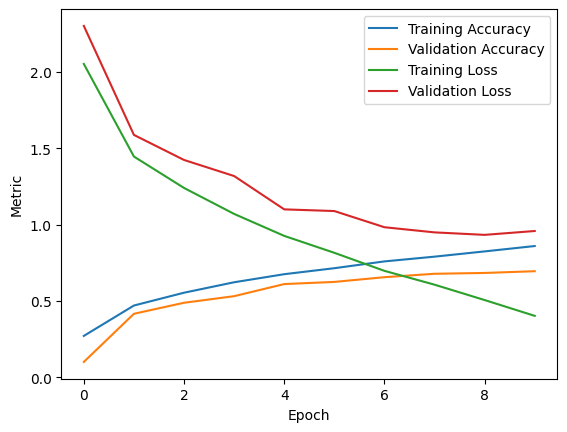

In [ ]:
resnet_18_arch = ResNet(((2, 64), (2, 128), (2, 256), (2, 512)), dropout_prob=0.5)

resnet_18_Model = Train_Model(resnet_18_arch, nn.CrossEntropyLoss(), torch.optim.SGD(resnet_18_arch.parameters(), lr=0.1, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
resnet_18_Model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

resnet_18_Model.Test_Model(testLoader)

macs, params = get_model_complexity_info(resnet_18_Model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("ResNet-18 Model Train Accuracy:", resnet_18_Model.Metrics["Training_Accuracy"][-1].item())
print("ResNet-18 Model Test Accuracy:", resnet_18_Model.Metrics["Test_Accuracy"])


resnet_18_Model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(resnet_18_Model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(resnet_18_Model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(resnet_18_Model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(resnet_18_Model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Current Epoch: 1
Training_Loss: 1.8319245903355301  | Validation_Loss: 2.3038829386234285
Training_Accuracy: 0.334322988986969  | Validation_Accuracy: 0.10414020717144012



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 2
Training_Loss: 1.352809954600729  | Validation_Loss: 1.5276148974895478
Training_Accuracy: 0.5130462050437927  | Validation_Accuracy: 0.4335263669490814



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 3
Training_Loss: 1.1135727979574994  | Validation_Loss: 1.3945702582597732
Training_Accuracy: 0.6030843257904053  | Validation_Accuracy: 0.4834957718849182



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 4
Training_Loss: 0.9523495644520802  | Validation_Loss: 1.1495821461081506
Training_Accuracy: 0.6655378937721252  | Validation_Accuracy: 0.5920819044113159



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 5
Training_Loss: 0.8106180771141295  | Validation_Loss: 1.1014847114682198
Training_Accuracy: 0.7171574234962463  | Validation_Accuracy: 0.6186562180519104



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 6
Training_Loss: 0.6805688343989621  | Validation_Loss: 0.9407380178570748
Training_Accuracy: 0.7638499736785889  | Validation_Accuracy: 0.687922477722168



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 7
Training_Loss: 0.5542453259799132  | Validation_Loss: 0.8839169621467591
Training_Accuracy: 0.8091976642608643  | Validation_Accuracy: 0.6987743973731995



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 8
Training_Loss: 0.4556585829349081  | Validation_Loss: 0.9918906196951867
Training_Accuracy: 0.84418123960495  | Validation_Accuracy: 0.6837729215621948



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 9
Training_Loss: 0.3715986979615157  | Validation_Loss: 0.8877873435616493
Training_Accuracy: 0.8721519708633423  | Validation_Accuracy: 0.7149891257286072



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 10
Training_Loss: 0.27744503708402063  | Validation_Loss: 0.8927417621016502
Training_Accuracy: 0.9066032767295837  | Validation_Accuracy: 0.7158383131027222



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Time Taken to Train: 0:06:01.060522
ResNet-18 Model Train Accuracy: 0.9066032767295837
ResNet-18 Model Test Accuracy: 0.7148999571800232
Macs:149.02 MMac | Params:11.18 M


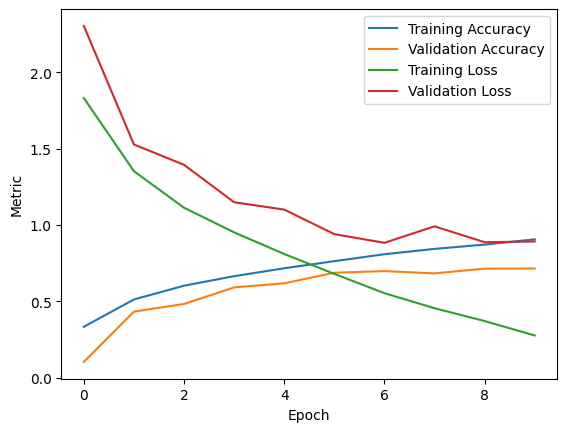

In [ ]:
resnet_18_arch = ResNet(((2, 64), (2, 128), (2, 256), (2, 512)), dropout_prob=0.6)

resnet_18_Model = Train_Model(resnet_18_arch, nn.CrossEntropyLoss(), torch.optim.SGD(resnet_18_arch.parameters(), lr=0.1, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
resnet_18_Model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

resnet_18_Model.Test_Model(testLoader)

macs, params = get_model_complexity_info(resnet_18_Model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("ResNet-18 Model Train Accuracy:", resnet_18_Model.Metrics["Training_Accuracy"][-1].item())
print("ResNet-18 Model Test Accuracy:", resnet_18_Model.Metrics["Test_Accuracy"])


resnet_18_Model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(resnet_18_Model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(resnet_18_Model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(resnet_18_Model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(resnet_18_Model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Current Epoch: 1
Training_Loss: 2.1119735552247163  | Validation_Loss: 2.3033480405807496
Training_Accuracy: 0.23959365487098694  | Validation_Accuracy: 0.09749995917081833



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 2
Training_Loss: 1.5034910653047502  | Validation_Loss: 1.788134717941284
Training_Accuracy: 0.44408294558525085  | Validation_Accuracy: 0.3238674998283386



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 3
Training_Loss: 1.2482452347020434  | Validation_Loss: 1.3811736017465592
Training_Accuracy: 0.5465492606163025  | Validation_Accuracy: 0.4943771958351135



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 4
Training_Loss: 1.0682448330958179  | Validation_Loss: 1.427471923828125
Training_Accuracy: 0.6247925758361816  | Validation_Accuracy: 0.49660158157348633



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 5
Training_Loss: 0.9114333918899488  | Validation_Loss: 1.2033282786607742
Training_Accuracy: 0.6822971701622009  | Validation_Accuracy: 0.5863478183746338



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 6
Training_Loss: 0.78617860025661  | Validation_Loss: 1.14228867739439
Training_Accuracy: 0.7275226712226868  | Validation_Accuracy: 0.612709105014801



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 7
Training_Loss: 0.674651435795863  | Validation_Loss: 0.9617243528366088
Training_Accuracy: 0.7654740810394287  | Validation_Accuracy: 0.6595232486724854



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 8
Training_Loss: 0.5609279041457328  | Validation_Loss: 0.9107674121856689
Training_Accuracy: 0.8051856756210327  | Validation_Accuracy: 0.6881256103515625



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 9
Training_Loss: 0.4549875101845735  | Validation_Loss: 0.9028334751725197
Training_Accuracy: 0.8438301682472229  | Validation_Accuracy: 0.7028067708015442



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 10
Training_Loss: 0.3660312102288957  | Validation_Loss: 1.001036661863327
Training_Accuracy: 0.874985933303833  | Validation_Accuracy: 0.6865720748901367



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Time Taken to Train: 0:06:00.219431
ResNet-18 Model Train Accuracy: 0.874985933303833
ResNet-18 Model Test Accuracy: 0.692300021648407
Macs:149.02 MMac | Params:11.18 M


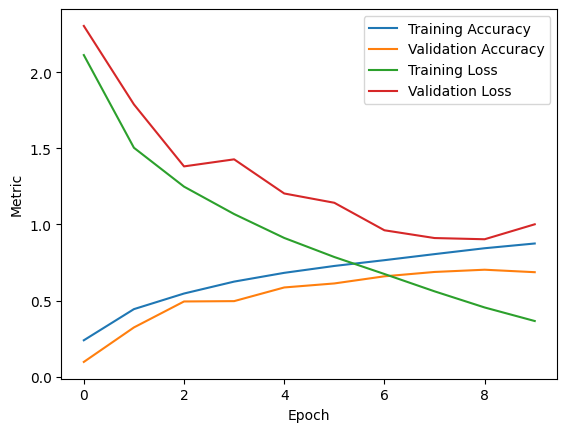

In [ ]:
resnet_18_arch = ResNet(((2, 64), (2, 128), (2, 256), (2, 512)), dropout_prob=0.7)

resnet_18_Model = Train_Model(resnet_18_arch, nn.CrossEntropyLoss(), torch.optim.SGD(resnet_18_arch.parameters(), lr=0.1, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
resnet_18_Model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

resnet_18_Model.Test_Model(testLoader)

macs, params = get_model_complexity_info(resnet_18_Model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("ResNet-18 Model Train Accuracy:", resnet_18_Model.Metrics["Training_Accuracy"][-1].item())
print("ResNet-18 Model Test Accuracy:", resnet_18_Model.Metrics["Test_Accuracy"])


resnet_18_Model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(resnet_18_Model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(resnet_18_Model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(resnet_18_Model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(resnet_18_Model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

## Baseline ResNet-11 Model

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Current Epoch: 1
Training_Loss: 1.9203853683107217  | Validation_Loss: 2.302927255630493
Training_Accuracy: 0.31021568179130554  | Validation_Accuracy: 0.09749995917081833



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 2
Training_Loss: 1.3337382184472053  | Validation_Loss: 1.5986849069595337
Training_Accuracy: 0.5150402784347534  | Validation_Accuracy: 0.41493234038352966



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 3
Training_Loss: 1.1022072354699397  | Validation_Loss: 1.2691435992717743
Training_Accuracy: 0.6079249978065491  | Validation_Accuracy: 0.5413525104522705



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 4
Training_Loss: 0.9528698085979291  | Validation_Loss: 1.3389787375926971
Training_Accuracy: 0.6651462316513062  | Validation_Accuracy: 0.5347520709037781



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 5
Training_Loss: 0.8097123329047184  | Validation_Loss: 1.088089856505394
Training_Accuracy: 0.7150576710700989  | Validation_Accuracy: 0.6281269192695618



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 6
Training_Loss: 0.6822672380003959  | Validation_Loss: 0.8953287228941917
Training_Accuracy: 0.7654353976249695  | Validation_Accuracy: 0.6942321062088013



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 7
Training_Loss: 0.573275554521828  | Validation_Loss: 0.8238397240638733
Training_Accuracy: 0.7996197938919067  | Validation_Accuracy: 0.7143969535827637



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 8
Training_Loss: 0.4619588576684332  | Validation_Loss: 0.825162723660469
Training_Accuracy: 0.8427842259407043  | Validation_Accuracy: 0.727864146232605



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 9
Training_Loss: 0.3664185085873695  | Validation_Loss: 0.8743855640292167
Training_Accuracy: 0.8744922876358032  | Validation_Accuracy: 0.7169471979141235



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 10
Training_Loss: 0.29351224973323237  | Validation_Loss: 0.9161376729607582
Training_Accuracy: 0.8994787931442261  | Validation_Accuracy: 0.7211050987243652



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Time Taken to Train: 0:05:51.414632
ResNet-11 Model Train Accuracy: 0.8994787931442261
ResNet-11 Model Test Accuracy: 0.7264000177383423
Macs:130.01 MMac | Params:11.11 M


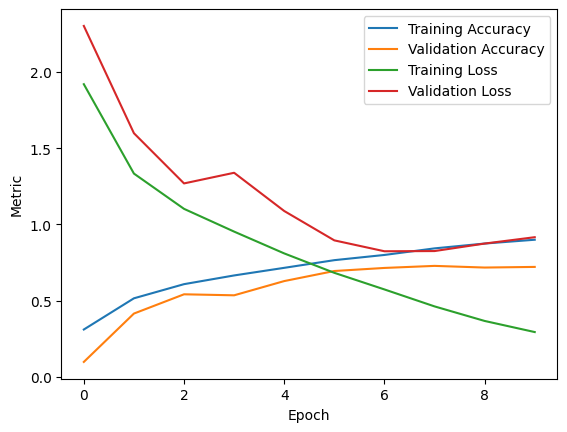

In [ ]:
resnet_11_arch = ResNet(((1, 64), (2, 128), (2, 256), (2, 512)), dropout_prob=0.5)

resnet_11_Model = Train_Model(resnet_11_arch, nn.CrossEntropyLoss(), torch.optim.SGD(resnet_11_arch.parameters(), lr=0.1, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
resnet_11_Model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

resnet_11_Model.Test_Model(testLoader)

macs, params = get_model_complexity_info(resnet_11_Model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("ResNet-11 Model Train Accuracy:", resnet_11_Model.Metrics["Training_Accuracy"][-1].item())
print("ResNet-11 Model Test Accuracy:", resnet_11_Model.Metrics["Test_Accuracy"])


resnet_11_Model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(resnet_11_Model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(resnet_11_Model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(resnet_11_Model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(resnet_11_Model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Current Epoch: 1
Training_Loss: 2.1148969010942302  | Validation_Loss: 2.303035670518875
Training_Accuracy: 0.2245291918516159  | Validation_Accuracy: 0.09743572026491165



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 2
Training_Loss: 1.5187565938682313  | Validation_Loss: 1.7401547640562058
Training_Accuracy: 0.4403412342071533  | Validation_Accuracy: 0.34259605407714844



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 3
Training_Loss: 1.2674385559786656  | Validation_Loss: 1.3991826504468918
Training_Accuracy: 0.5373694896697998  | Validation_Accuracy: 0.4916440546512604



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 4
Training_Loss: 1.0688908768307632  | Validation_Loss: 1.287127923965454
Training_Accuracy: 0.6182361245155334  | Validation_Accuracy: 0.5415431261062622



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 5
Training_Loss: 0.9178276870660721  | Validation_Loss: 1.1483622074127198
Training_Accuracy: 0.6752587556838989  | Validation_Accuracy: 0.5964298248291016



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 6
Training_Loss: 0.8007486538522562  | Validation_Loss: 1.0055504128336907
Training_Accuracy: 0.7196400761604309  | Validation_Accuracy: 0.6406849026679993



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 7
Training_Loss: 0.6780711089729503  | Validation_Loss: 1.0575392469763756
Training_Accuracy: 0.76433265209198  | Validation_Accuracy: 0.6405761241912842



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 8
Training_Loss: 0.5687830476624192  | Validation_Loss: 0.8553524523973465
Training_Accuracy: 0.8013219833374023  | Validation_Accuracy: 0.7131334543228149



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 9
Training_Loss: 0.45039207920147356  | Validation_Loss: 0.9578380100429058
Training_Accuracy: 0.8438314199447632  | Validation_Accuracy: 0.6875093579292297



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 10
Training_Loss: 0.3618135621213609  | Validation_Loss: 0.8662128001451492
Training_Accuracy: 0.8747886419296265  | Validation_Accuracy: 0.7192062139511108



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Time Taken to Train: 0:05:53.034536
ResNet-11 Model Train Accuracy: 0.8747886419296265
ResNet-11 Model Test Accuracy: 0.7235000133514404
Macs:130.01 MMac | Params:11.11 M


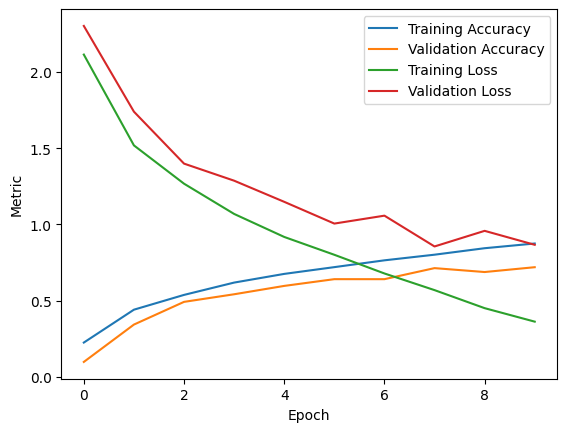

In [ ]:
resnet_11_arch = ResNet(((1, 64), (2, 128), (2, 256), (2, 512)), dropout_prob=0.6)

resnet_11_Model = Train_Model(resnet_11_arch, nn.CrossEntropyLoss(), torch.optim.SGD(resnet_11_arch.parameters(), lr=0.1, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
resnet_11_Model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

resnet_11_Model.Test_Model(testLoader)

macs, params = get_model_complexity_info(resnet_11_Model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("ResNet-11 Model Train Accuracy:", resnet_11_Model.Metrics["Training_Accuracy"][-1].item())
print("ResNet-11 Model Test Accuracy:", resnet_11_Model.Metrics["Test_Accuracy"])


resnet_11_Model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(resnet_11_Model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(resnet_11_Model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(resnet_11_Model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(resnet_11_Model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Current Epoch: 1
Training_Loss: 1.8442626728373728  | Validation_Loss: 2.301820236444473
Training_Accuracy: 0.33598968386650085  | Validation_Accuracy: 0.10430389642715454



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 2
Training_Loss: 1.31369620523635  | Validation_Loss: 1.508184626698494
Training_Accuracy: 0.5192899107933044  | Validation_Accuracy: 0.429706871509552



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 3
Training_Loss: 1.061252503638055  | Validation_Loss: 1.2895371347665787
Training_Accuracy: 0.6230364441871643  | Validation_Accuracy: 0.5377196073532104



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 4
Training_Loss: 0.8950005978535694  | Validation_Loss: 1.0652697175741195
Training_Accuracy: 0.6860072016716003  | Validation_Accuracy: 0.61391282081604



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 5
Training_Loss: 0.7479129467800165  | Validation_Loss: 1.1000690057873725
Training_Accuracy: 0.7393454313278198  | Validation_Accuracy: 0.6267838478088379



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 6
Training_Loss: 0.6229839799510446  | Validation_Loss: 0.939916904270649
Training_Accuracy: 0.784057080745697  | Validation_Accuracy: 0.6731537580490112



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 7
Training_Loss: 0.5063590194768967  | Validation_Loss: 0.944263206422329
Training_Accuracy: 0.8257254958152771  | Validation_Accuracy: 0.6750701069831848



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 8
Training_Loss: 0.39991705869413485  | Validation_Loss: 0.8051315799355507
Training_Accuracy: 0.8633029460906982  | Validation_Accuracy: 0.7321537733078003



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 9
Training_Loss: 0.31336412517128476  | Validation_Loss: 0.8514767304062844
Training_Accuracy: 0.8943172097206116  | Validation_Accuracy: 0.7327529191970825



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Current Epoch: 10
Training_Loss: 0.23697302912830548  | Validation_Loss: 0.8574344336986541
Training_Accuracy: 0.9190104007720947  | Validation_Accuracy: 0.7410175800323486



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Time Taken to Train: 0:05:50.338943
ResNet-11 Model Train Accuracy: 0.9190104007720947
ResNet-11 Model Test Accuracy: 0.7396000623703003
Macs:130.01 MMac | Params:11.11 M


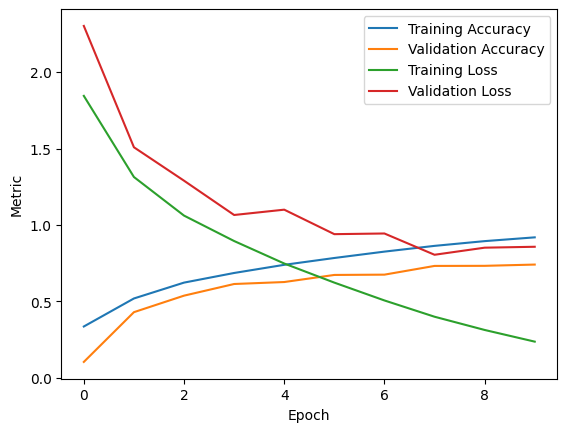

In [ ]:
resnet_11_arch = ResNet(((1, 64), (2, 128), (2, 256), (2, 512)), dropout_prob=0.7)

resnet_11_Model = Train_Model(resnet_11_arch, nn.CrossEntropyLoss(), torch.optim.SGD(resnet_11_arch.parameters(), lr=0.1, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
resnet_11_Model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

resnet_11_Model.Test_Model(testLoader)

macs, params = get_model_complexity_info(resnet_11_Model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("ResNet-11 Model Train Accuracy:", resnet_11_Model.Metrics["Training_Accuracy"][-1].item())
print("ResNet-11 Model Test Accuracy:", resnet_11_Model.Metrics["Test_Accuracy"])


resnet_11_Model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(resnet_11_Model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(resnet_11_Model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(resnet_11_Model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(resnet_11_Model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()